First lets start with the basic imports.

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field

The following dataclass represents one ingredient for our muesli, containing all the necessary information.

In [130]:
@dataclass
class Ingredient:
    name: str
    fat: float
    saturated_fatty_acids: float
    carbs: float
    sugar: float
    protein: float
    fiber: float
    salt: float
    kcal: float    

Those are the ingredients I found in my kitchen.

In [131]:
OATMEAL = Ingredient("OATMEAL", 7, 1.3, 58.7, 0.7, 13.5, 9.3, 0, 372)
SOY_FLAKES = Ingredient("SOY FLAKES", 20.6, 2.6, 3.1, 3.1, 40.8, 0, 0.01, 398)
QUINOA = Ingredient("QUINOA", 4.7, 0.8, 72, 1.4, 9.9, 4.7, 0.01, 378)
AMARANTH = Ingredient("AMARANTH", 4.9, 1.5, 65, 1.1, 12, 8.3, 0.01, 371)
SPELT = Ingredient("SPELT", 2.4, 0.4, 66.3, 2.3, 12.8, 8, 0.05, 354)
FLAXSEEDS = Ingredient("FLAXSEEDS", 43, 5.3, 3, 1, 22, 26, 0.15, 539)

The mixture is one combination of different ingredients. Each ingredient has a 
different amount in the final mixture, specified in grams.

In [166]:
@dataclass
class Mixture:
    ingredients: list[tuple[Ingredient, float]] = field(default_factory=list)
    total_carbs: float = field(init=False)
    total_sugar: float = field(init=False)
    total_fat: float = field(init=False)
    total_saturated_fatty_acids: float = field(init=False)
    total_protein: float = field(init=False)
    total_fiber: float = field(init=False)
    total_salt: float = field(init=False)
    total_kcal: float = field(init=False)
    total_weight: float = field(init=False)

    def __post_init__(self):
        self.total_weight = sum(amount for _, amount in self.ingredients)
        self.total_carbs = sum(ingredient.carbs / 100 * amount for ingredient, amount in self.ingredients)
        self.total_sugar = sum(ingredient.sugar / 100 * amount for ingredient, amount in self.ingredients)
        self.total_fat = sum(ingredient.fat / 100 * amount for ingredient, amount in self.ingredients)
        self.total_saturated_fatty_acids = sum(ingredient.saturated_fatty_acids / 100 * amount for ingredient, amount in self.ingredients)
        self.total_protein = sum(ingredient.protein / 100 * amount for ingredient, amount in self.ingredients)
        self.total_fiber = sum(ingredient.fiber / 100 * amount for ingredient, amount in self.ingredients)
        self.total_salt = sum(ingredient.salt / 100 * amount for ingredient, amount in self.ingredients)
        self.total_kcal = sum(ingredient.kcal * amount for ingredient, amount in self.ingredients) / 100

    def __eq__(self, other) -> bool:
        return self.ingredients == other.ingredients

    def __str__(self) -> str:
        ingredients_str = "\n".join(f"{amount:.0f}g {ingredient.name}" for ingredient, amount in self.ingredients)
        return f"""Mixture\n{ingredients_str}\n{self.total_carbs:.2f}g carbs ({self.total_sugar:.2f}g sugar) / {self.total_fat:.2f}g fat ({self.total_saturated_fatty_acids:.2f}g saturated) / {self.total_protein:.2f}g protein / {self.total_kcal:.2f}kcal"""


Now we need a function to create a new offspring of two given mixtures (the parents).
There are a lot of ways to do this, but we will use the mean combination by taking the mean amount of the left and the right mixture of each ingredient. After the reproduction, the new mixture is a mixture of the two parents.

In [159]:
def reproduce(left_mixture: Mixture, right_mixture: Mixture) -> Mixture:
    left_ingredients, _ = np.array_split(left_mixture.ingredients, 2)
    _, right_ingredients = np.array_split(right_mixture.ingredients, 2)
    return Mixture(np.concatenate((left_ingredients, right_ingredients)))

Like in the real world, our descendants can mutate. In our context, this means that the amounts will be multiplied with a random value where the mean is 1 and the standard deviation is 0.2.

In [172]:

def mutate(mixture: Mixture) -> Mixture:
    ingredients, amounts = zip(*mixture.ingredients)
    new_amounts = np.around(amounts * np.random.normal(1, 0.2, len(amounts)), 0)
    return Mixture(list(zip(ingredients, new_amounts)))

Last but not least, we need to define a fitness function. This functions tells us, how good or bad our mixture is in terms of our defined goals.
We want to minimize the number of sugar, saturated fatty acids and salt. On the other hand, we want to maximize the number of protein and fiber.
Also we want to reach exactly 400 kcal and not more than 10g of fat in total.

In [199]:

def fitness_score(mixture: Mixture) -> float:
    return np.abs(400 - mixture.total_kcal) * -2 \
        + mixture.total_protein * 3 \
        + mixture.total_carbs * -0.1 \
        + mixture.total_fat * -2 \
        + mixture.total_saturated_fatty_acids * -2 \
        + mixture.total_sugar * -10 \
        + mixture.total_salt * -20 \
        #+ np.abs(40 - mixture.total_carbs) * -1 \
        #+ np.abs(20 - mixture.total_protein) * -1 \
        #+ np.abs(10 - mixture.total_fat) * -1 \
        #+ mixture.total_fiber * 2 \

To generate a random population, we need a function that generates a random mixture. In this case, we will pick a random number between 1 and 10 as amount for every ingredient.

In [173]:
def random_mixture() -> Mixture:
    return Mixture([
        (OATMEAL, np.random.randint(0, 50)), 
        (SOY_FLAKES, np.random.randint(0, 50)),
        (QUINOA, np.random.randint(0, 50)),
        (AMARANTH, np.random.randint(0, 50)),
        (FLAXSEEDS, np.random.randint(0, 50)),
        (SPELT, np.random.randint(0, 50)),
    ])

To make things a bit easier, we'll define a function to create a pandas dataframe for mixtures.

In [174]:
def mixture_to_dict(mixture: Mixture) -> dict:
    return {
                "carbs": mixture.total_carbs,
                "fat": mixture.total_fat,
                "protein": mixture.total_protein,
                "sugar": mixture.total_sugar,
                "saturated_fatty_acids": mixture.total_saturated_fatty_acids,
                "fiber": mixture.total_fiber,
                "salt": mixture.total_salt,
                "kcal": mixture.total_kcal,
                "SOY FLAKES": next(amount for ingredient, amount in mixture.ingredients if ingredient == SOY_FLAKES),
                "OATMEAL": next(amount for ingredient, amount in mixture.ingredients if ingredient == OATMEAL),
                "QUINOA": next(amount for ingredient, amount in mixture.ingredients if ingredient == QUINOA),
                "AMARANTH": next(amount for ingredient, amount in mixture.ingredients if ingredient == AMARANTH),
                "SPELT": next(amount for ingredient, amount in mixture.ingredients if ingredient == SPELT),
                "FLAXSEEDS": next(amount for ingredient, amount in mixture.ingredients if ingredient == FLAXSEEDS),
                "fitness_score": fitness_score(mixture),
    }

def mixtures_to_df(mixtures: list[Mixture]) -> pd.DataFrame:
    return pd.DataFrame([mixture_to_dict(mixture) for mixture in mixtures])

In [178]:
m1 = random_mixture()
m2 = random_mixture()
c1 = reproduce(m1, m2)
c2 = reproduce(m2, m1)
print(mixtures_to_df([m1, m2, c2, c1]).to_string())

     carbs     fat  protein  sugar  saturated_fatty_acids   fiber    salt    kcal  SOY FLAKES  OATMEAL  QUINOA  AMARANTH  SPELT  FLAXSEEDS  fitness_score
0   77.406  25.449    32.37  2.889                  3.669  18.951  0.0849  716.13          24       24       6        39     48         36      -616.4206
1   98.553  31.367    38.91  3.364                  4.392  22.447  0.0945  888.12          28       48      38        19     43         43      -958.6483
2  114.658  29.457    40.41  3.629                  4.341  22.687  0.0885  942.29          28       48      38        39     48         36     -1061.4418
3   61.301  27.359    30.87  2.624                  3.720  18.711  0.0909  661.96          24       24       6        19     43         43      -513.6271


Now the interesting part. We start by generating a random population of size `POPULATION_SIZE`. After that, the cycle will be repeated `EPOCHS` times.

In each cycle, we start by sorting the population by fitness score. Then, we select the 100 best individuals of our population and create a new offsprings by reproducing them.
Duplicated individuals are removed. To reach our destinated population size, we add random individuals until we reach the desired size.

In [216]:
EPOCHS = 1000
POPULATION_SIZE = 500
HISTORY = []

# we start with a random population
population = [random_mixture() for _ in range(POPULATION_SIZE)]
for epoch in range(EPOCHS):
    # we start by sorting the population by fitness score
    population.sort(key=lambda m: fitness_score(m), reverse=True)
    
    if epoch % 100 == 0:
        print(f"POPULATION: {epoch}\tBEST FITNESS: {fitness_score(population[0]):.2f}")
    
    # for fancy charts at the end, we'll add the current top 20 of our population to the history
    for mixture in population[:30]:
        d = mixture_to_dict(mixture)
        d["generation"] = epoch
        HISTORY.append(d)


    # shuffle the current top 100 of our population and split / zip into a new list of tuples
    # those will be our moms and dads, e.g. [(mom1, dad1), (mom2, dad2), ...]
    population = population[:50]
    list_of_parents = list(zip(*np.array_split(np.random.permutation(population), 2)))

    # now that we have our parents, we can reproduce them ... 🍆 💦 😏
    for mom, dad in list_of_parents:
        cute_child_one = mutate(reproduce(mom, dad))
        cute_child_two = mutate(reproduce(dad, mom))
        population.append(cute_child_one)
        population.append(cute_child_two)
    
    # there is no place for two of the same child, so we remove all duplicates
    unique_population = []
    for mixture in population:
        if mixture not in unique_population:
            unique_population.append(mixture)
    population = unique_population
    
    # now we have a population of unique mixtures, we can fill the rest with random mixtures
    while len(population) < POPULATION_SIZE:
        population.append(random_mixture())
    

# at the end, we'll sort the population by fitness score and print the top 20
population.sort(key=lambda m: fitness_score(m), reverse=True)
mixtures_to_df(population[:20])

POPULATION: 0	BEST FITNESS: 17.81
POPULATION: 100	BEST FITNESS: 24.61
POPULATION: 200	BEST FITNESS: 25.82
POPULATION: 300	BEST FITNESS: 25.90
POPULATION: 400	BEST FITNESS: 26.26
POPULATION: 500	BEST FITNESS: 26.37
POPULATION: 600	BEST FITNESS: 26.55
POPULATION: 700	BEST FITNESS: 26.62
POPULATION: 800	BEST FITNESS: 26.62
POPULATION: 900	BEST FITNESS: 26.69


,carbs,fat,protein,sugar,saturated_fatty_acids,fiber,salt,kcal,SOY FLAKES,OATMEAL,QUINOA,AMARANTH,SPELT,FLAXSEEDS,fitness_score
0,33.362,14.051,27.704,2.063,1.972,5.075,0.0106,400.10,50.0,44.0,0.0,1.0,8.0,1.0,26.6878
1,33.425,14.030,27.689,2.067,1.974,5.065,0.0107,400.09,50.0,43.0,0.0,2.0,8.0,1.0,26.6525
2,33.488,14.009,27.674,2.071,1.976,5.055,0.0108,400.08,50.0,42.0,0.0,3.0,8.0,1.0,26.6172
3,33.551,13.988,27.659,2.075,1.978,5.045,0.0109,400.07,50.0,41.0,0.0,4.0,8.0,1.0,26.5819
4,33.905,13.940,27.423,2.027,1.970,5.171,0.0101,400.01,49.0,45.0,0.0,2.0,7.0,1.0,26.5665
5,33.501,13.984,27.682,2.083,1.965,5.052,0.0112,399.91,50.0,42.0,0.0,2.0,9.0,1.0,26.5639
6,33.614,13.967,27.644,2.079,1.980,5.035,0.0110,400.06,50.0,40.0,0.0,5.0,8.0,1.0,26.5466
7,33.677,13.946,27.629,2.083,1.982,5.025,0.0111,400.05,50.0,39.0,0.0,6.0,8.0,1.0,26.5113
8,33.564,13.963,27.667,2.087,1.967,5.042,0.0113,399.90,50.0,41.0,0.0,3.0,9.0,1.0,26.4886
9,33.740,13.925,27.614,2.087,1.984,5.015,0.0112,400.04,50.0,38.0,0.0,7.0,8.0,1.0,26.4760


Now we can generate some fancy charts to visualize the results.

In [217]:
history_frame = pd.DataFrame(HISTORY)

<AxesSubplot:xlabel='generation', ylabel='fitness_score'>

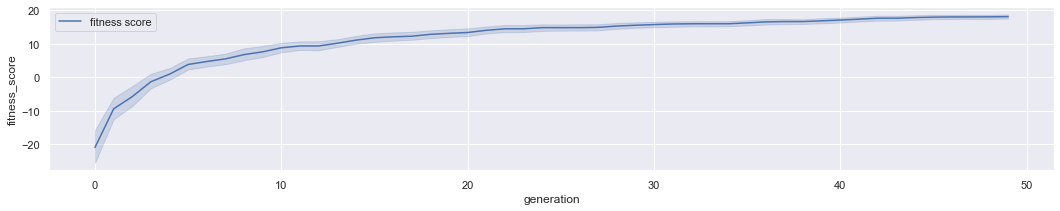

In [218]:
sns.set(rc={'figure.figsize':(18, 3)})
sns.lineplot(data=history_frame[:30*50], x="generation", y="fitness_score", label="fitness score")

As we can see, the first 40 generations are pretty random, but after that, the fitness score is pretty stable and looks like it doesn't change much.

<AxesSubplot:xlabel='generation', ylabel='fitness_score'>

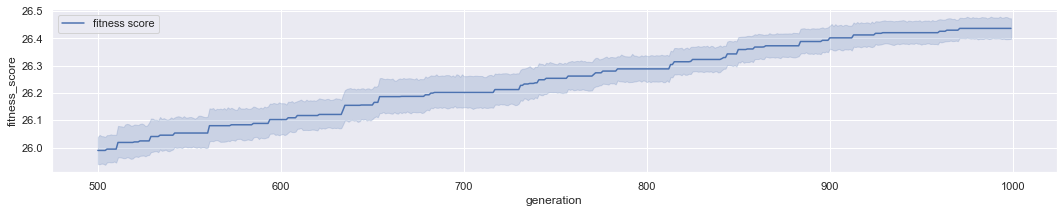

In [220]:
sns.set(rc={'figure.figsize':(18, 3)})
sns.lineplot(data=history_frame[30*500:], x="generation", y="fitness_score", label="fitness score")

If we look closer, we can see that the fitness score does indeed increase over time, even after 1000 generations.

<AxesSubplot:xlabel='generation (epoch)', ylabel='grams'>

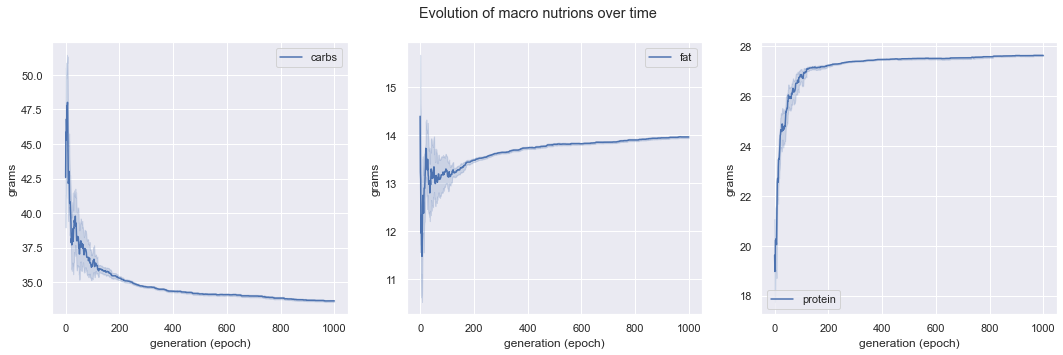

In [221]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  
fig.suptitle('Evolution of macro nutrions over time')

axes[0].set_ylabel('grams')
axes[0].set_xlabel('generation (epoch)')  
axes[1].set_ylabel('grams')
axes[1].set_xlabel('generation (epoch)')  
axes[2].set_ylabel('grams')
axes[2].set_xlabel('generation (epoch)')  
  
sns.lineplot(ax=axes[0], data=history_frame, x="generation", y="carbs", label="carbs")
sns.lineplot(ax=axes[1], data=history_frame, x="generation", y="fat", label="fat")
sns.lineplot(ax=axes[2], data=history_frame, x="generation", y="protein", label="protein")

<AxesSubplot:xlabel='generation (epoch)', ylabel='grams'>

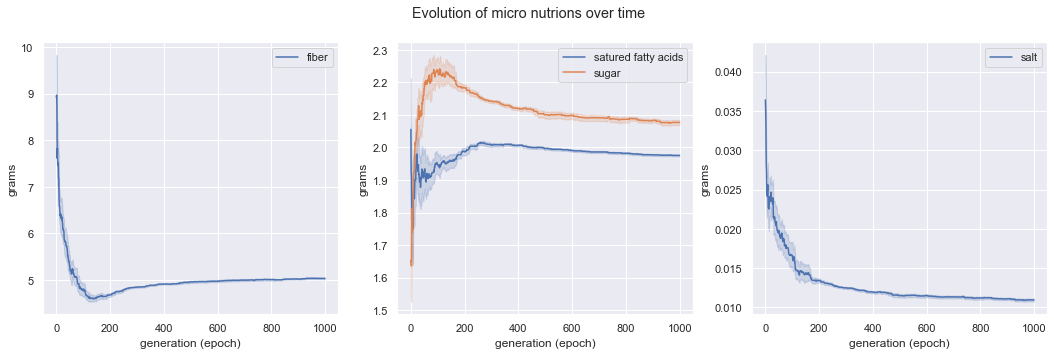

In [222]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  
fig.suptitle('Evolution of micro nutrions over time')

axes[0].set_ylabel('grams')
axes[0].set_xlabel('generation (epoch)')  
axes[1].set_ylabel('grams')
axes[1].set_xlabel('generation (epoch)')  
axes[2].set_ylabel('grams')
axes[2].set_xlabel('generation (epoch)')  
  
sns.lineplot(ax=axes[0], data=history_frame, x="generation", y="fiber", label="fiber")
sns.lineplot(ax=axes[1], data=history_frame, x="generation", y="saturated_fatty_acids", label="satured fatty acids")
sns.lineplot(ax=axes[1], data=history_frame, x="generation", y="sugar", label="sugar")
sns.lineplot(ax=axes[2], data=history_frame, x="generation", y="salt", label="salt")

<AxesSubplot:xlabel='generation (epoch)', ylabel='grams'>

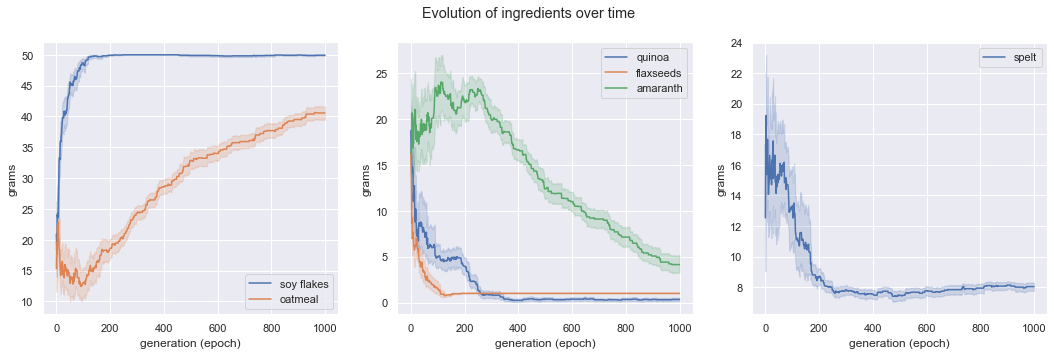

In [223]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  
fig.suptitle('Evolution of ingredients over time')

axes[0].set_ylabel('grams')
axes[0].set_xlabel('generation (epoch)')  
axes[1].set_ylabel('grams')
axes[1].set_xlabel('generation (epoch)')  
axes[2].set_ylabel('grams')
axes[2].set_xlabel('generation (epoch)')  

sns.lineplot(ax=axes[0], data=history_frame, x="generation", y="SOY FLAKES", label="soy flakes")
sns.lineplot(ax=axes[0], data=history_frame, x="generation", y="OATMEAL", label="oatmeal")
sns.lineplot(ax=axes[1], data=history_frame, x="generation", y="QUINOA", label="quinoa")
sns.lineplot(ax=axes[1], data=history_frame, x="generation", y="FLAXSEEDS", label="flaxseeds")
sns.lineplot(ax=axes[1], data=history_frame, x="generation", y="AMARANTH", label="amaranth")
sns.lineplot(ax=axes[2], data=history_frame, x="generation", y="SPELT", label="spelt")

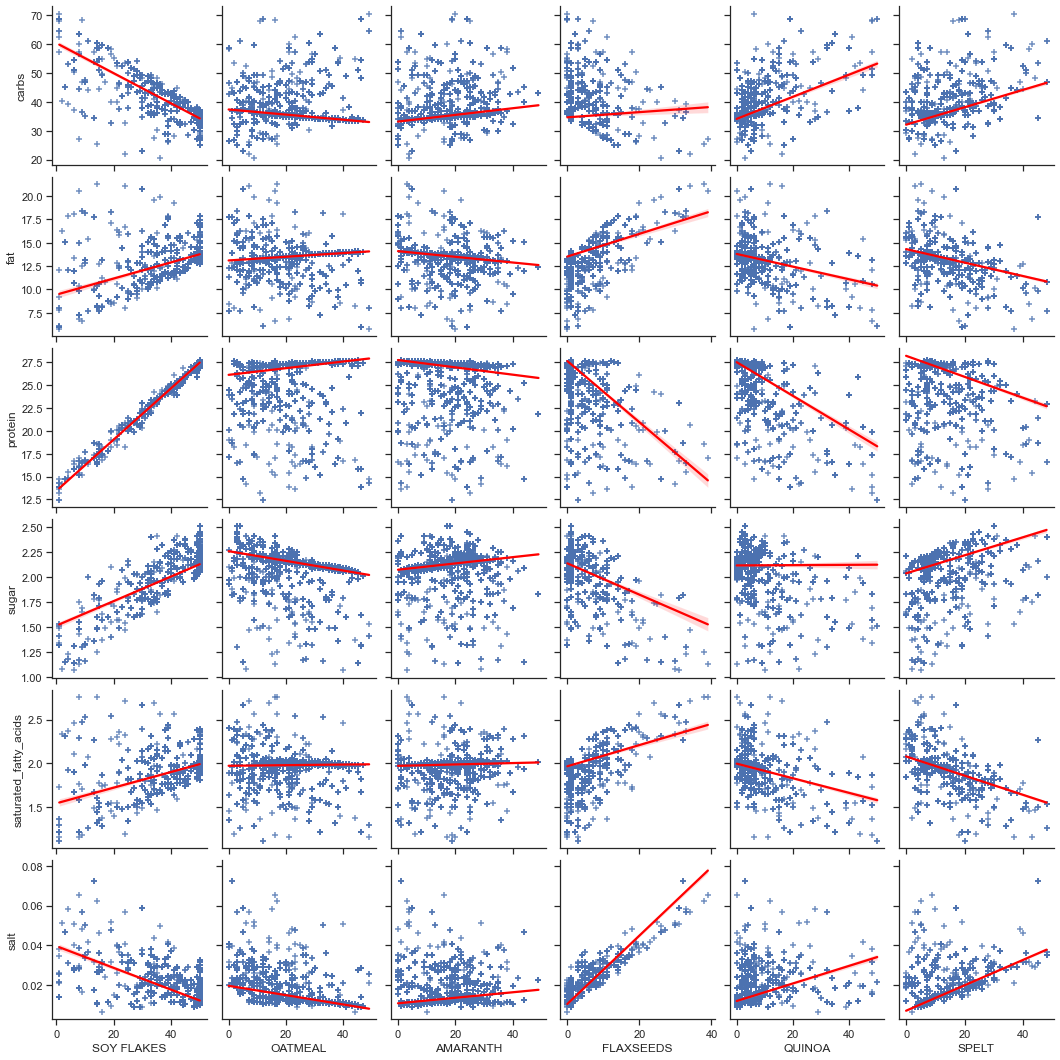

In [225]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=history_frame, plot_kws={'line_kws':{'color':'red'}, "marker": "+"}, kind="reg", y_vars=["carbs", "fat", "protein", "sugar", "saturated_fatty_acids", "salt"], x_vars=["SOY FLAKES","OATMEAL","AMARANTH", "FLAXSEEDS", "QUINOA", "SPELT"])